# Ideation



In [1]:
import yfinance as yf
import pandas as pd
from helper import get_tickers, get_extreme
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

lowess = sm.nonparametric.lowess



In [2]:
tickers = get_tickers()

# just use first one for ideation
data = pd.DataFrame(yf.Ticker(tickers[0]).history(period = "10y")["Close"])
data.head()


,Close
Date,
2016-02-04 00:00:00-05:00,43.079189
2016-02-05 00:00:00-05:00,42.361061
2016-02-08 00:00:00-05:00,41.667706
2016-02-09 00:00:00-05:00,41.436588
2016-02-10 00:00:00-05:00,41.428337


In [3]:
data["100dma"] = data[["Close"]].rolling("100D").mean()
data["100dms"] = data[["Close"]].rolling("100D").std()
data.tail()


,Close,100dma,100dms
Date,,,
2026-01-28 00:00:00-05:00,146.839996,141.101488,2.751172
2026-01-29 00:00:00-05:00,146.699997,141.223633,2.812865
2026-01-30 00:00:00-05:00,145.500000,141.336150,2.828837
2026-02-02 00:00:00-05:00,146.309998,141.474685,2.886548
2026-02-03 00:00:00-05:00,145.539993,141.534469,2.907032


In [4]:
data["z"] = (data["Close"] - data["100dma"])/data["100dms"]
data.sample(5)
# higher z more expensive, lower z cheaper


,Close,100dma,100dms,z
Date,,,,
2016-10-10 00:00:00-04:00,49.376190,48.839368,0.746926,0.718708
2022-10-03 00:00:00-04:00,74.974052,81.109110,3.449293,-1.778642
2021-11-26 00:00:00-05:00,95.376877,95.944594,1.966709,-0.288663
2022-11-21 00:00:00-05:00,81.353607,78.950324,3.826852,0.628005
2023-05-31 00:00:00-04:00,86.875328,85.766449,1.894996,0.585162


Lowess curve to find trend. 

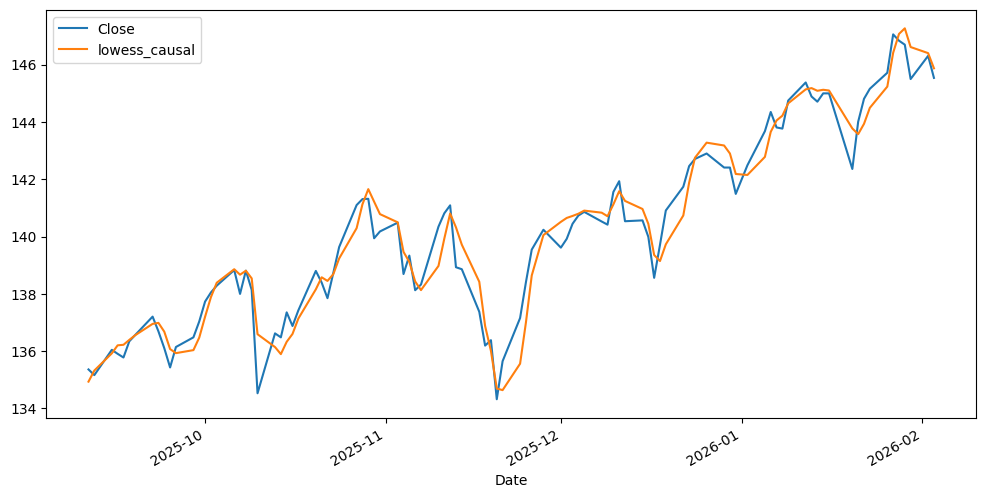

In [5]:
window_size = 100 

def get_causal_lowess(window):
    # This function takes the current window and returns ONLY the last smoothed point
    # frac=0.1 means it uses 10% of the window to smooth the final point
    res = lowess(window, np.arange(len(window)), frac=0.1, it=0)
    return res[-1, 1]  # Return the last smoothed value (the current day)

# 2. Apply it using a rolling window
# This ensures each 'lowess' value only knows about the past
data["lowess_causal"] = data["Close"].rolling(window=window_size).apply(get_causal_lowess)
data["lowess_gradient"] = np.gradient(data["lowess_causal"])
plt.figure(figsize=(12, 6))
ax = plt.gca() 
data.tail(100).plot(y = "Close", ax = ax)
data.tail(100).plot(y = "lowess_causal", ax = ax)
plt.show()


In [6]:
data


,Close,100dma,100dms,z,lowess_causal,lowess_gradient
Date,,,,,,
2016-02-04 00:00:00-05:00,43.079189,43.079189,NaN,NaN,NaN,NaN
2016-02-05 00:00:00-05:00,42.361061,42.720125,0.507793,-0.707107,NaN,NaN
2016-02-08 00:00:00-05:00,41.667706,42.369319,0.705778,-0.994099,NaN,NaN
2016-02-09 00:00:00-05:00,41.436588,42.136136,0.741335,-0.943632,NaN,NaN
2016-02-10 00:00:00-05:00,41.428337,41.994576,0.715807,-0.791050,NaN,NaN
...,...,...,...,...,...,...
2026-01-28 00:00:00-05:00,146.839996,141.101488,2.751172,2.085842,147.075112,0.427721
2026-01-29 00:00:00-05:00,146.699997,141.223633,2.812865,1.946899,147.270881,-0.228720
2026-01-30 00:00:00-05:00,145.500000,141.336150,2.828837,1.471930,146.617673,-0.432773


In [ ]:
get_extreme(data.tail(50))
# finds the max/min price and how many days ago it was


(np.float64(147.05999755859375), 10)

So now two strats, one shorting when z is low and buying when z is high and other doing the opposite? How to implement percentage retracement

In [8]:
trade_data = data.dropna()

for i, row in trade_data.iterrows():
    print(row)


Close              45.537491
100dma             46.584413
100dms              0.734404
z                  -1.425540
lowess_causal      45.199927
lowess_gradient    -0.099736
Name: 2016-06-28 00:00:00-04:00, dtype: float64
Close              46.398903
100dma             46.586910
100dms              0.733457
z                  -0.256330
lowess_causal      45.424586
lowess_gradient     0.439443
Name: 2016-06-29 00:00:00-04:00, dtype: float64
Close              47.026127
100dma             46.599194
100dms              0.733511
z                   0.582041
lowess_causal      46.078814
lowess_gradient     0.661894
Name: 2016-06-30 00:00:00-04:00, dtype: float64
Close              47.126488
100dma             46.619750
100dms              0.727733
z                   0.696325
lowess_causal      46.748375
lowess_gradient     0.444432
Name: 2016-07-01 00:00:00-04:00, dtype: float64
Close              46.541069
100dma             46.633358
100dms              0.716996
z                  -0.128